# PyTorch Toolkit: 02 - Logistic Regression

This notebook is the second entry in a series exploring PyTorch for deep learning. As a natural next step to linear regression, we'll build a classic logistic regression model for binary classification.

**Goal:** Predict a binary outcome (0 or 1) based on input features using a linear decision boundary. We will:
1.  Create linearly separable synthetic data.
2.  Define a logistic regression model using a single `nn.Linear` layer and a sigmoid activation.
3.  Train the model using a classification-specific loss function and an optimizer.
4.  Evaluate the model's accuracy and visualize its (linear) decision boundary.

Along the way, we'll cover:

- **Output activation:** Using `torch.sigmoid` to convert linear outputs into probabilities.
- **Classification loss functions:** Using `nn.BCELoss` (Binary Cross-Entropy Loss).
- **Handling categorical data:** Binary labels (0s and 1s).
- **Model evaluation:** Accuracy as an intuitive measure of performance.


In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## 1. Data preparation
We'll start by creating simple, linearly separable synthetic data for a binary classification problem.

We'll generate two Gaussian clusters (class 0 and class 1) that are separable by a straight line. This setup is ideal for demonstrating a logistic regression model and its linear decision boundary.


In [20]:
# Create 1000 samples of linearly separable data
torch.manual_seed(30)
n_samples = 1000

# Generate two Gaussian clusters
class0 = torch.randn(n_samples // 2, 2) + torch.tensor([-1.5, -1.0])
class1 = torch.randn(n_samples // 2, 2) + torch.tensor([1.5, 1.0])

X = torch.cat([class0, class1], dim=0)
y = torch.cat([
    torch.zeros(n_samples // 2),
    torch.ones(n_samples // 2)
], dim=0)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


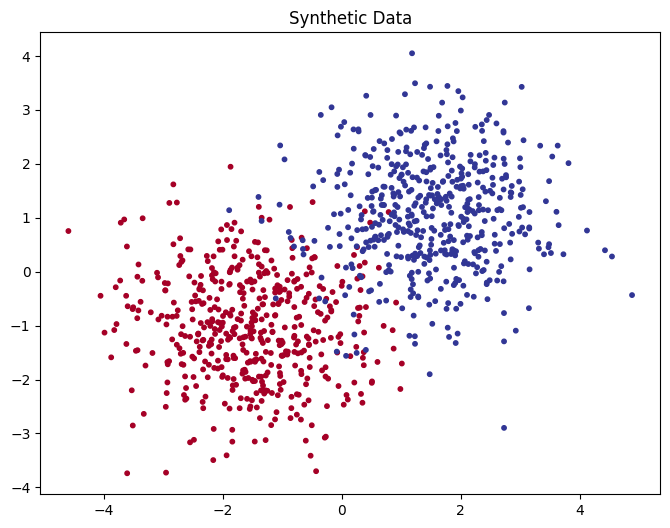

In [21]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, s=10)
plt.title("Synthetic Data")
plt.show()


It can be seen that the data is clearly linearly separable by a straight line, let's see if our model can learn to separate the data.

## 2. Model architecture

We'll implement a classic logistic regression model: a single `nn.Linear` layer followed by a sigmoid activation.

- The linear layer computes a weighted sum with bias: $ z = W x + b $
- The sigmoid maps $ z $ to a probability in $ [0, 1] $: $$ \sigma(z) = 1/(1+e^{-z}) $$

This architecture yields a linear decision boundary, which matches our linearly separable dataset.

### The Sigmoid activation function
After the linear layer, we apply a **Sigmoid activation function** (`torch.sigmoid`). 
- A linear layer outputs real-valued scores.
- The sigmoid squashes them into $[0, 1]$, interpretable as the probability of class 1.


In [22]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=2, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self.linear(x))


## 3. Training the model


### 3.1 Setup: Loss Function, Optimizer, and Evaluation Metric

- **Loss Function:** For binary classification, we use `nn.BCELoss` (Binary Cross-Entropy Loss). This loss function is designed to work with probabilities (the output of our sigmoid function). It compares the predicted probability with the actual class (0 or 1) and penalizes the model more heavily for confident but incorrect predictions.

- **Optimizer:** We'll stick with `torch.optim.SGD` (Stochastic Gradient Descent) to update our model's parameters and minimize the loss.

- **Evaluation Metric:** Loss is great for training, but for classification, we often want a more intuitive measure of performance. We'll calculate **accuracy**, which is simply the proportion of correct predictions our model makes. We'll write a helper function for this.


In [23]:
torch.manual_seed(42)
model = LogisticRegressionModel()

# Loss function
loss_fn = nn.BCELoss()

# Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# Evaluation metric
def accuracy_fn(y_true, y_pred):
    # Round predictions to 0 or 1
    predicted_labels = torch.round(y_pred)
    # Calculate number of correct predictions
    correct = torch.eq(y_true, predicted_labels).sum().item()
    # Calculate accuracy
    acc = (correct / len(y_pred)) * 100
    return acc


### 3.2 The training loop

This is where we'll repeatedly expose the model to the data and allow it to learn. We will loop for a set number of *epochs*, and in each loop, we will perform the essential training steps. We'll also calculate the accuracy on both the training and test sets to monitor our model's performance.


In [24]:
epochs = 1000

# Training loop
for epoch in range(epochs):
    # --- Training ---
    model.train()
    
    # 1. Forward pass (model outputs probabilities)
    y_pred_probs = model(X_train).squeeze()  # shape: [N]
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_pred_probs, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred_probs)
    
    # 3. Reset gradients
    optimizer.zero_grad()
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Gradient descent
    optimizer.step()
    
    # --- Testing ---
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass (probabilities)
        test_pred_probs = model(X_test).squeeze()
        
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_pred_probs, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred_probs)
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.2737, Acc: 94.75% | Test loss: 0.2351, Test acc: 97.00%
Epoch: 100 | Loss: 0.1325, Acc: 96.00% | Test loss: 0.0923, Test acc: 97.50%
Epoch: 200 | Loss: 0.1177, Acc: 96.00% | Test loss: 0.0789, Test acc: 97.00%
Epoch: 300 | Loss: 0.1122, Acc: 95.88% | Test loss: 0.0743, Test acc: 97.00%
Epoch: 400 | Loss: 0.1095, Acc: 95.88% | Test loss: 0.0722, Test acc: 97.00%
Epoch: 500 | Loss: 0.1080, Acc: 95.75% | Test loss: 0.0710, Test acc: 97.00%
Epoch: 600 | Loss: 0.1071, Acc: 95.75% | Test loss: 0.0703, Test acc: 97.00%
Epoch: 700 | Loss: 0.1065, Acc: 95.75% | Test loss: 0.0699, Test acc: 97.00%
Epoch: 800 | Loss: 0.1060, Acc: 95.75% | Test loss: 0.0696, Test acc: 97.00%
Epoch: 900 | Loss: 0.1058, Acc: 95.75% | Test loss: 0.0694, Test acc: 97.00%


## 4. Evaluation and visualization
With our model trained, we can now visualize its predictions to see how well it's learned to separate the two classes. We'll create a function to plot the decision boundary that our model has learned. This boundary is the line where the model switches from predicting one class to the other.


In [25]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works best with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_probs = model(X_to_pred_on)

    # Test for multi-class or binary and adjust probs to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_probs, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(y_probs)

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


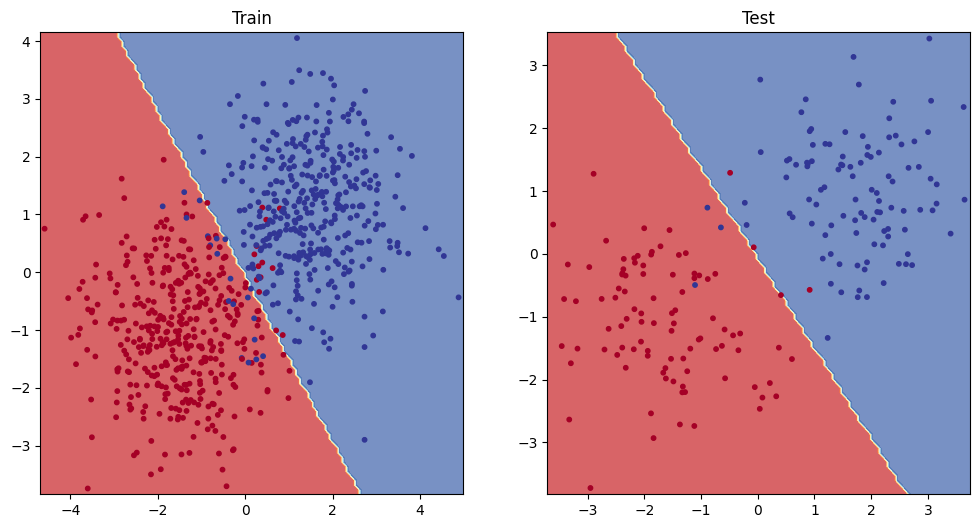

In [26]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)


## 5. Summary

In this notebook, we built and trained a classic logistic regression model (single linear layer + sigmoid) on linearly separable data.

We saw how to:
- Convert model outputs to probabilities using the **sigmoid function**.
- Use **Binary Cross-Entropy Loss (`nn.BCELoss`)** to train the model.
- Evaluate the model's performance using **accuracy**.
- **Visualize the linear decision boundary** learned by logistic regression.

This provides a baseline for binary classification and a reference point before moving to non-linear models.